# Pathfinding Algorithms

Pathfinding algorithms are a fundamental aspect of graph theory and computer science, focusing on finding the shortest path between two points in a graph. These algorithms are essential for various applications, including route planning in transportation systems, network routing protocols, and maze-solving in games.

I have always had an interest in how Google Maps actually figures out how to get from A to B the quickest. Learning about these algorithms has been both rewarding and extremely interesting to me.

# Why Pathfinding Algorithms are Useful

Pathfinding algorithms are invaluable tools in various domains due to their ability to efficiently determine the shortest path between two locations in a graph (Not just Google Maps, as I had naively originally thought). 

Some key reasons why pathfinding algorithms are useful include:

Efficient Route Planning: Pathfinding algorithms help in determining the most efficient route between two points, saving time and resources, especially in transportation systems and logistics. Like the quickest way from the pub to the Kebab shop. 

Optimization: They enable optimization of resources by identifying the shortest path, which can lead to cost savings and improved efficiency. Like the quickest way from the kebab shop to another kebab shop. 

Network Routing: In computer networks, pathfinding algorithms are crucial for determining the optimal path for data packets to traverse from the source to the destination. Like the quickest way for your phone to order another kebab from deliveroo because you dropped yours all over your new shoes on the way home. 

In this Jupyter Notebook, we will explore two widely used pathfinding algorithms: Dijkstra's algorithm and Prim's algorithm. These algorithms provide solutions to different pathfinding problems, and understanding their principles and implementations can be beneficial in various applications.

# The two lads that we'll be covering: 

In this notebook, we will focus on the following pathfinding algorithms:

**Dijkstra's Algorithm:** Dijkstra's algorithm is a classic algorithm for finding the shortest paths between nodes in a graph. It works well for finding the shortest path from a single source node to all other nodes in a graph with non-negative edge weights.

**Prim's Algorithm:** Prim's algorithm is a greedy algorithm used for finding the minimum spanning tree of a connected, undirected graph. It efficiently constructs a subtree that includes every vertex and has the minimum total edge cost.

By studying these algorithms, we aim to gain insights into their working principles, understand their complexities, and learn how to implement them in Python for solving real-world pathfinding problems.

Let's dive into exploring Dijkstra's and Prim's algorithms! Let us not dwell on former kebabs and associated mishaps. 

# Dijkstra's Algorithm

Dijkstra's algorithm is a widely used algorithm in computer science, named after Dutch computer scientist Edsger W. Dijkstra, who first described it in 1956. It is primarily used for finding the shortest paths between nodes in a graph. 

The algorithm is particularly well-suited for scenarios where the graph represents a network of interconnected nodes with non-negative edge weights, such as road networks, computer networks, and transportation systems. See below for an example of said network. 

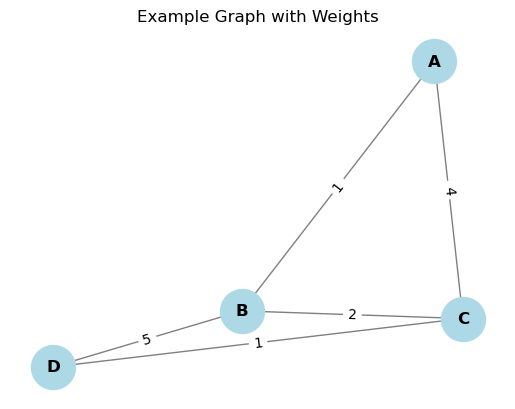

In [179]:
# Importing required libraries
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

# Add nodes
G.add_node('A')
G.add_node('B')
G.add_node('C')
G.add_node('D')

# Add edges with weights
G.add_edge('A', 'B', weight=1)
G.add_edge('A', 'C', weight=4)
G.add_edge('B', 'C', weight=2)
G.add_edge('B', 'D', weight=5)
G.add_edge('C', 'D', weight=1)

# Define positions for nodes. This spring_layout function is quite loaded. Each vertex connected to another vertex experiences an attraction inversely
#proportional to the weight of the connecting edge. All vertex pairs experience a mutual repulsion. Vertexes are randomly assigned positions, net force
#on each vertex calculated, vertex moved slightly. This is repeated until equilibrium. Notice if you run this cell repeatedly even though weights and 
#vertexes are constant, the graph always changes
pos = nx.spring_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='lightblue')

# Draw edges with labels
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Draw node labels
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

# Show the graph
plt.title("Example Graph with Weights")
plt.axis('off')
plt.show()


## How does this algorithm work? 

Dijkstra's algorithm works by iteratively exploring nodes in the graph, starting from a specified source node. It maintains a set of tentative distances from the source node to all other nodes, initially set to infinity for all nodes except the source node, which is set to 0. At each iteration, the algorithm selects the node with the smallest tentative distance and updates the tentative distances of its neighbors if a shorter path is found.

Here's a step-by-step explanation of how Dijkstra's algorithm works:

 - Initialization: Set the tentative distance of the source node to 0 and all other nodes to infinity. Create an empty priority queue to store nodes based on their tentative distances. Note this priority queue is a heap data structure, implementing min heaping. We'll investigate this a smidgeon further after we implement the actual algorithm. Just consider it a black box for now that outputs the closest neighbour. 

 - Exploration: While there are nodes in the priority queue, select the node with the smallest tentative distance.

 - Update Neighbors: For each neighbor of the selected node, calculate the tentative distance from the source node through the selected node. If this tentative distance is shorter than the current distance, update the distance.

 - Repeat: Repeat the above two steps until all reachable nodes have been explored.

 - Termination: Once all reachable nodes have been explored, the algorithm terminates, and the shortest paths from the source node to all other nodes are known.

By following these steps, Dijkstra's algorithm efficiently finds the shortest paths from a single source node to all other nodes in the graph.

Let's get to it shall we? We'll look at a bidirectional graph. All these streets are two way. 

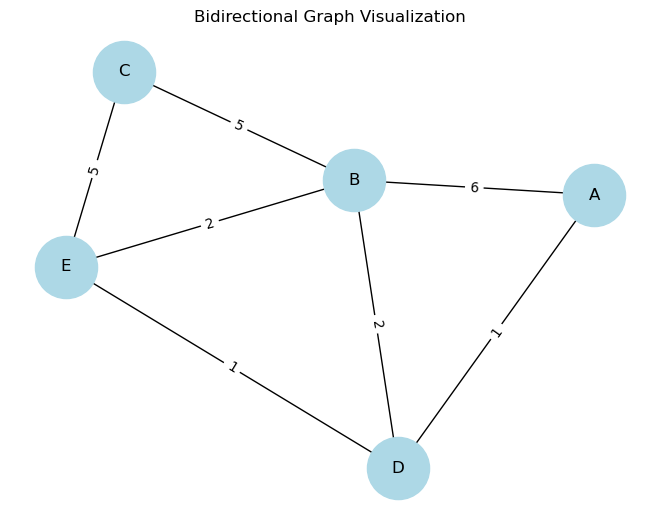

In [180]:
# Create an undirected graph
G = nx.Graph()

# Add nodes and edges with weights
edges = [
    ('A', 'B', 6),
    ('A', 'D', 1),
    ('B', 'D', 2),
    ('B', 'E', 2),
    ('D', 'E', 1), 
    ('B', 'C', 5), 
    ('E', 'C', 5)
]

# Add edges in both directions
for edge in edges:
    G.add_edge(edge[0], edge[1], weight=edge[2])
    G.add_edge(edge[1], edge[0], weight=edge[2])

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)

# Add edge labels
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the graph
plt.title("Bidirectional Graph Visualization")
plt.show()


We're going to be really cool and original here, and see what the best way to get from 'A' to every other node is, and how long it is. Imagine these units are in Buzz Lightyears. 

In [235]:
import heapq

def dijkstra(graph, start):
    # Initialize distances, paths, and visited vertices
    distances = {node: float('inf') for node in graph}
    paths = {node: [] for node in graph}
    #Visited set, which is what we'll check to see if we've been to the vertex before
    visited = set()
    #Here we are initialising lists to track both the vertexes, and distances travelled for the total trip
    travelled_order = []
    distance_travelled = []
    #Here we're initialising a dummy variable to start. This is a retentitive value, that will hold onto the value of the last vertex visited, until
    #we travel to a new one. This is to track the nodes in the visited set
    tmp = start

    # Initialize priority queue
    pq = [(0, start, [start])]  # Tuple format: (distance, node, path)

    while pq:
        # Pop the node with the smallest distance from the priority queue
        current_distance, current_node, current_path = heapq.heappop(pq)
        
        # Check if the node has already been visited
        if current_node not in visited:
            #Getting the node order
            travelled_order.append(current_node)
            #Once we move on from the starting node, we must access specific values within the inner dictionaries of the graph.
            #This must be calculated using the previous vertex to the current. Hence why we dont reassign tmp until after this value is obtained
            if current_node != start:
                distance_travelled.append(graph[tmp][current_node])
            #reassigning tmp 
            tmp = current_node
            
        if current_node in visited:
            #break out of the loop to the next element in the priority queue if we've already been to that spot 
            continue

        # Mark the node as visited. Set is handy as even if we managed to add extra nodes, it would only show each item once
        visited.add(current_node)

        # Update distance and path for the current node. This is how we get the shortest path to each vertex
        distances[current_node] = current_distance
        paths[current_node] = current_path

        # Print the shortest path to the current node
        #print(f"Shortest path to {current_node}: {' -> '.join(current_path)} (Distance: {current_distance})")

        # If all vertices have been visited, break the loop
        if len(visited) == len(graph):
            break

        # Iterate through neighbors of the current node
        for neighbor, weight in graph[current_node].items():
            # Calculate new distance and path per vertex
            distance = current_distance + weight
            path = current_path + [neighbor]

            # If a shorter path to the neighbor is found, update the priority queue
            heapq.heappush(pq, (distance, neighbor, path))

    # Calculate total shortest path length
    total_shortest_path_length = sum(distances.values())
    # Print the shortest path to all nodes
    print(f" Shortest path to travel to all nodes from {start} is : {' -> '.join(travelled_order)} and is {sum(distance_travelled)} units long")
    return distances, paths, travelled_order, sum(distance_travelled)

# Example graph
graph = {
    'A': {'B': 6, 'D': 1},
    'B': {'A': 6, 'D': 2, 'E': 2, 'C': 5},
    'C': {'B': 5, 'E': 5},
    'D': {'A': 1, 'B': 2, 'E': 1},
    'E': {'B': 2 ,'C':5, 'D': 1}
}

# Run Dijkstra's algorithm with 'A' as the source node
distances, paths, order , total_distance  = dijkstra(graph, 'A')


 Shortest path to travel to all nodes from A is : A -> D -> E -> B -> C and is 9 units long


Oh my gosh this is groundbreaking. We have split the atom. It's handy out, we have succesfully implemented Dijkstra's algorithm, there is one other way to implement this I saw online using an Object Oriented approach. The link to this is below:

The vertexes, edges and graph are represented as instances of their own respective classes, let's get cracking on the new method shall we? 

https://youtu.be/_B5cx-WD5EA?si=uA7EvqYeB_MyDiPv

## New Method 

Creating classes for the Edges, Vertexes, and Graph. For simplicity's sake we'll use the same graph from above. 

In [182]:
class Graph:
    def __init__(self):
        self.adjacency_list = {}

In [183]:
class Edge:
    #Here in the __init__ Constructor method, we initialise weight and vertex to none. vertex indicates the node to which the edge is joining
    #This will make more sense when we see the adjaceny list for the graph
    def __init__(self, weight = None, vertex = None):
        self.weight = weight
        self.vertex = vertex

In [184]:
class Vertex: 
    def __init__(self, value = None):
        self.value = value

just to visualise the graph again while I write the adjacency list: 

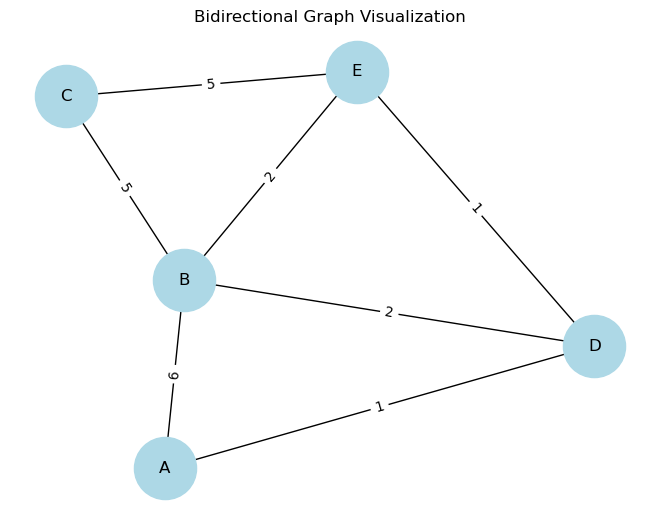

In [185]:
# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000)

# Add edge labels
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

# Show the graph
plt.title("Bidirectional Graph Visualization")
plt.show()

In [186]:
#Instantiating our Vertices as Uppercase
A = Vertex("A")
B = Vertex("B")
C = Vertex("C")
D = Vertex("D")
E = Vertex("E")

In [187]:
#Creating our network, while simultaneously instantiating our edges. We had to do the vertices first as the edges need them as parameters
our_graph = {
    A : [Edge(weight = 6, vertex = B), Edge(weight = 1, vertex = D)],
    B : [Edge(weight = 6, vertex = A), Edge(weight = 5, vertex = C), Edge(weight = 2, vertex = D), Edge(weight = 2, vertex = E)],
    C : [Edge(weight = 5, vertex = B),Edge(weight = 5, vertex = E)],
    D : [Edge(weight = 1, vertex = A),Edge(weight = 2, vertex = B),Edge(weight = 1, vertex = E)],
    E : [Edge(weight = 1, vertex = D),Edge(weight = 2, vertex = B),Edge(weight = 5, vertex = C)]
}

In [188]:
graph_instance = Graph()
graph_instance.adjacency_list = our_graph

In [189]:
#Well, this way of doing things is certainly more succinct than the above!
def dijkstra_2(graph, start): #Same arguments
    previous = {x : None for x in graph.adjacency_list.keys()} #creatings dictionaries for the previous vertex to each vertex
    distance = {x : float('inf') for x in graph.adjacency_list.keys()} # The distance to each vertex
    visited = { x : False for x in graph.adjacency_list.keys()} # And whether we have visited them or not 
    distance[start] = 0 # Here is where we appear out of thin air on the initial vertex
    queue = [(0,start)] # Starting out our priority queue
    while queue: #While the list is not empty
        distance_travelled, removed =  heapq.heappop(queue) #using the minheap property to pop out the closest node
        visited[removed] = True #Saying that we have just been to the node were currently at
        for edge in graph.adjacency_list[removed]: # iterating through all of the edges leaving our current vertex
            if visited[edge.vertex]: #if the vertex at the end of the edge we're looking at has been visited already, continue on to the next one
                continue
            new_distance = distance_travelled + edge.weight #if we haven't been there, calculate how far away from our starting position it is
            if new_distance < distance[edge.vertex]:#if it is closer than we had previously thought:
                distance[edge.vertex] = new_distance #record this new minimum distance in the distance dictionary
                previous[edge.vertex] = removed #Record that the node we visited this new node from to obtain the shortcut was the 'removed' node
                heapq.heappush(queue, (new_distance, edge.vertex)) #Push this new vertex and it's distance into the heap
    return previous, distance, visited
            
previous, distance, visited  = dijkstra_2(graph_instance, A)

In [190]:
#Here are the vertexes, from which we were last at, for each vertex. In non ye olde english this means the previous lol 
print("Previous items:")
for key, value in previous.items():
    if value == None: 
        print(key.value, ":", value)
    else:
        print(key.value, ":", value.value)

Previous items:
A : None
B : D
C : E
D : A
E : D


This matches what we have above, for the quickest way to each node. Not proud of how long it took me to cop I needed to state the object atributes in the for loop above. 

In [191]:
#Here are the vertexes, from which we were last at, for each vertex. In non ye olde english this means the previous lol 
print("Previous items:")
for key, value in distance.items():
    print(key.value, ":", value)

Previous items:
A : 0
B : 3
C : 7
D : 1
E : 2


Wowzers, this matches us again. We are on a winner here

In [192]:
#Here are the vertexes, from which we were last at, for each vertex. In non ye olde english this means the previous lol 
print("Previous items:")
for key, value in visited.items():
    print(key.value, ":", value)

Previous items:
A : True
B : True
C : True
D : True
E : True


We've been everywhere, mister worldwide.

### A very, very important implementation of Dijkstra's Algorithm

In Ireland, we have a tradition called 12 pubs. For this, a group of pals must go to 12 different pubs, and have a drink from each. This is a timeless classic, and very healthy tradition. It does however, have complications, like 'Oh my gosh, what is the optimised pub crawl route through this sprawling metropolis!? I haven't had a beer in over 20 minutes! What am I to do!?' and one of your friends tactically arriving late to avoid pub 1. Fear not, I have the solution. This is what Dijkstra invented his algorithm for. 

In my hometown of Youghal, pubs can be over 850 metres apart! That's over a kilometre! What I am going to do to find the optimised 12 pubs route, is create a network, where each vertex is a pub. Every edge is the distance between. Every vertex is connected to every other, for as we all know, on any given pub, any other pub is a valid destination (even though we always follow the exact same rigid route). 

Lets visualise the network, and yes I used google maps to get these weights (Dijkstra again). 

In [221]:
import pandas as pd
network = pd.read_csv(r'C:\Users\conor\Documents\Python\Pathfinding Algorithms\Network Points.txt', delimiter = ',')
network.index = ['Point Bar', 'Ahernes', 'Berties', 'The Nook', 'The Red Store','Old Imperial', 'Anchor', 'Tynans', 'Moby Dicks', ' Quays', "JD's",'Hennesys']
network

,Point Bar,Ahernes,Berties,The Nook,The Red Store,Old Imperial,Anchor,Tynans,Moby Dicks,Quays,JD's,Hennesys
Point Bar,NaN,85.0,140.0,200.0,240.0,300.0,450.0,270.0,700.0,850.0,700.0,800.0
Ahernes,NaN,NaN,55.0,120.0,160.0,220.0,400.0,180.0,650.0,750.0,600.0,700.0
Berties,NaN,NaN,NaN,62.0,100.0,170.0,300.0,130.0,550.0,700.0,550.0,650.0
The Nook,NaN,NaN,NaN,NaN,40.0,100.0,260.0,63.0,500.0,650.0,500.0,600.0
The Red Store,NaN,NaN,NaN,NaN,NaN,62.0,220.0,23.0,450.0,600.0,450.0,550.0
Old Imperial,NaN,NaN,NaN,NaN,NaN,NaN,170.0,39.0,400.0,550.0,400.0,500.0
Anchor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,200.0,260.0,400.0,400.0,500.0
Tynans,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,450.0,550.0,400.0,500.0
Moby Dicks,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.0,180.0,140.0
Quays,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,110.0,100.0


In [222]:
import math
# Create an empty dictionary
result_dict = {}

# Iterate through the DataFrame
for column_name, column in network.items():
    for index_name, value in column.items():
        # Create a tuple (column name, index name) as key
        key = (column_name, index_name)
        # Assign the value to the key in the dictionary
        result_dict[key] = value

# Iterate through the dictionary and remove entries with NaN values
cleaned_dict = {key: value for key, value in result_dict.items() if not math.isnan(value)}

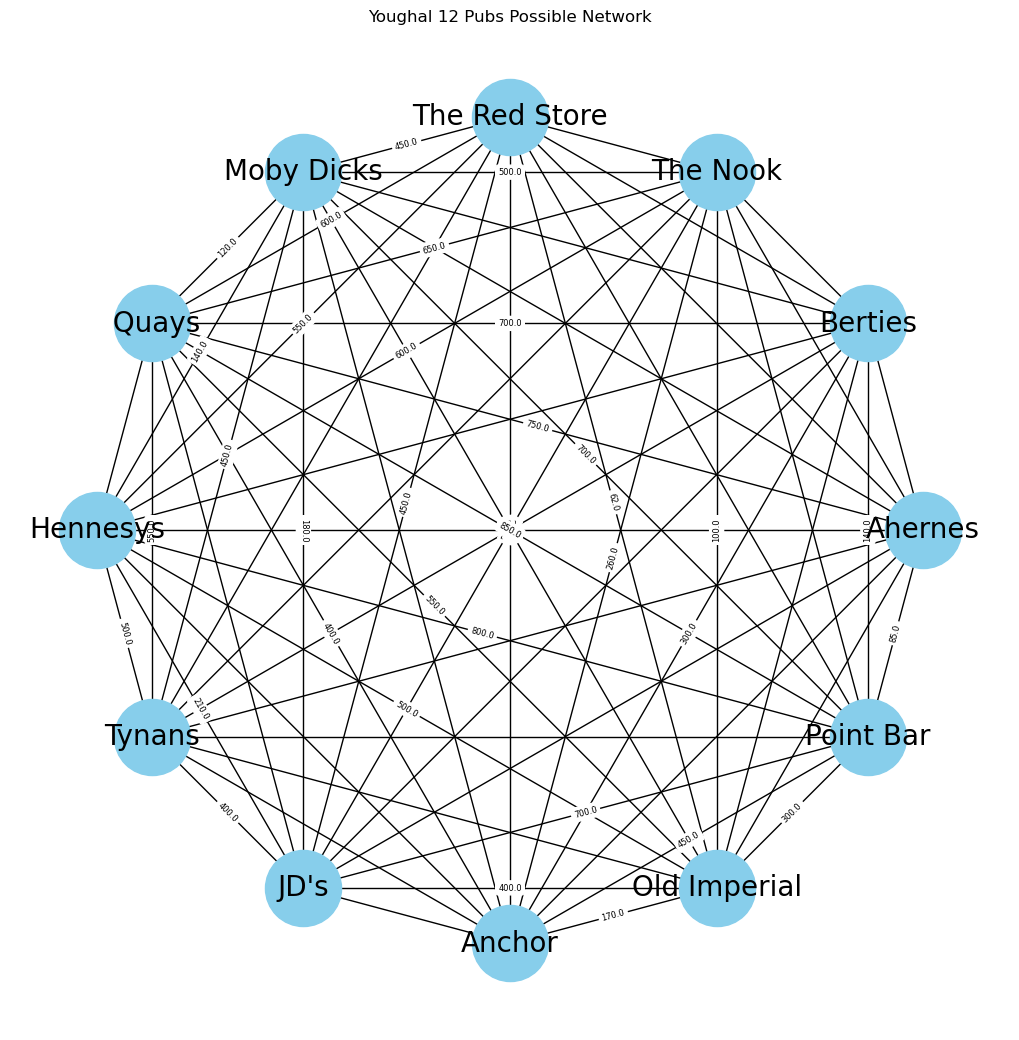

In [223]:
import matplotlib.pyplot as plt

# Extracting unique names from keys
unique_names = set(name for names in cleaned_dict.keys() for name in names)

# Create a complete graph with nodes corresponding to unique names
G = nx.complete_graph(unique_names)

# Assign weights to edges based on values in the dictionary
for edge in G.edges():
    names = tuple(sorted([edge[0], edge[1]]))  # Sort names to match dictionary keys
    if names in cleaned_dict:
        G[edge[0]][edge[1]]['weight'] = cleaned_dict[names]

# Set positions of nodes in a circle
pos = nx.circular_layout(G)

# Draw the graph with larger size and smaller font size for edge labels
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=20)  # Adjust node size and font size as needed
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'), font_size=6)  # Adjust font size as needed

# Display the graph
plt.title("Youghal 12 Pubs Possible Network")
plt.show()

Now we just need to reformat our pub distance dataframe. We need to make sure each column, has the distance to overy other pub (every other index). We'll do this by converting to an array, transposing it, and adding it to the original dataframe. We'll have to convert NaN to 0. 

Then we're going to have to convert this to a dictionary of dictionaries for the original Dijkstra's code. The second code was more succinct, but rewriting all edges as objects for the above would be a nightmare. 

In [224]:
import numpy as np
a =network.fillna(0) 
b = np.array(network.T.fillna(0))
a = a.astype(int)
b = b.astype(int)
pub_df = a + b
pub_df

,Point Bar,Ahernes,Berties,The Nook,The Red Store,Old Imperial,Anchor,Tynans,Moby Dicks,Quays,JD's,Hennesys
Point Bar,0,85,140,200,240,300,450,270,700,850,700,800
Ahernes,85,0,55,120,160,220,400,180,650,750,600,700
Berties,140,55,0,62,100,170,300,130,550,700,550,650
The Nook,200,120,62,0,40,100,260,63,500,650,500,600
The Red Store,240,160,100,40,0,62,220,23,450,600,450,550
Old Imperial,300,220,170,100,62,0,170,39,400,550,400,500
Anchor,450,400,300,260,220,170,0,200,260,400,400,500
Tynans,270,180,130,63,23,39,200,0,450,550,400,500
Moby Dicks,700,650,550,500,450,400,260,450,0,120,180,140
Quays,850,750,700,650,600,550,400,550,120,0,110,100


In [225]:
# Initialize an empty dictionary
result_dict = {}

# Iterate over the columns of the DataFrame
for col_name, col in pub_df.items():
    # Initialize a nested dictionary for the column
    result_dict[col_name] = {}
    
    # Iterate over the rows of the DataFrame
    for index, value in col.items():
        if value != 0:
            # Add the value to the nested dictionary if it's not 0
            result_dict[col_name][index] = value

# Print the resulting dictionary
print(result_dict)


{'Point Bar': {'Ahernes': 85, 'Berties': 140, 'The Nook': 200, 'The Red Store': 240, 'Old Imperial': 300, 'Anchor': 450, 'Tynans': 270, 'Moby Dicks': 700, ' Quays': 850, "JD's": 700, 'Hennesys': 800}, 'Ahernes': {'Point Bar': 85, 'Berties': 55, 'The Nook': 120, 'The Red Store': 160, 'Old Imperial': 220, 'Anchor': 400, 'Tynans': 180, 'Moby Dicks': 650, ' Quays': 750, "JD's": 600, 'Hennesys': 700}, 'Berties': {'Point Bar': 140, 'Ahernes': 55, 'The Nook': 62, 'The Red Store': 100, 'Old Imperial': 170, 'Anchor': 300, 'Tynans': 130, 'Moby Dicks': 550, ' Quays': 700, "JD's": 550, 'Hennesys': 650}, 'The Nook': {'Point Bar': 200, 'Ahernes': 120, 'Berties': 62, 'The Red Store': 40, 'Old Imperial': 100, 'Anchor': 260, 'Tynans': 63, 'Moby Dicks': 500, ' Quays': 650, "JD's": 500, 'Hennesys': 600}, 'The Red Store': {'Point Bar': 240, 'Ahernes': 160, 'Berties': 100, 'The Nook': 40, 'Old Imperial': 62, 'Anchor': 220, 'Tynans': 23, 'Moby Dicks': 450, ' Quays': 600, "JD's": 450, 'Hennesys': 550}, 'Old 

In [252]:
#Declaring these lads, setting distance as an infinite value, so that whenever a smaller distance pops up, we'll nick that and store it in this variable 
min_path_distance = float('inf')
min_path = []
for i in list(network.columns):
    distances, paths, order , total_distance = dijkstra(result_dict,i)
    if total_distance < min_path_distance:
        min_path_distance = total_distance
        min_path = order

 Shortest path to travel to all nodes from Point Bar is : Point Bar -> Ahernes -> Berties -> The Nook -> The Red Store -> Tynans -> Old Imperial -> Anchor -> JD's -> Moby Dicks -> Hennesys ->  Quays and is 1294 units long
 Shortest path to travel to all nodes from Ahernes is : Ahernes -> Berties -> Point Bar -> The Nook -> The Red Store -> Tynans -> Old Imperial -> Anchor -> JD's -> Moby Dicks -> Hennesys ->  Quays and is 1487 units long
 Shortest path to travel to all nodes from Berties is : Berties -> Ahernes -> The Nook -> The Red Store -> Tynans -> Point Bar -> Old Imperial -> Anchor -> JD's -> Moby Dicks -> Hennesys ->  Quays and is 1798 units long
 Shortest path to travel to all nodes from The Nook is : The Nook -> The Red Store -> Berties -> Tynans -> Old Imperial -> Ahernes -> Point Bar -> Anchor -> JD's -> Moby Dicks -> Hennesys ->  Quays and is 1884 units long
 Shortest path to travel to all nodes from The Red Store is : The Red Store -> Tynans -> The Nook -> Old Imperial -> 

In [254]:
print(f" Best path to travel to all pubs is : {' -> '.join(min_path)} and is {min_path_distance} metres long")

 Best path to travel to all pubs is :  Quays -> Hennesys -> JD's -> Moby Dicks -> Anchor -> Old Imperial -> Tynans -> The Red Store -> The Nook -> Berties -> Ahernes -> Point Bar and is 1224 metres long


OK , this has the regular starting pub at the end, and as this is a bidirectional network, we're going to flip this list around as the difference will be the same, and we want to start in that pub. 

In [253]:
print(f" Best path to travel to all pubs is : {' -> '.join(min_path[::-1])} and is {min_path_distance} metres long")

 Best path to travel to all pubs is : Point Bar -> Ahernes -> Berties -> The Nook -> The Red Store -> Tynans -> Old Imperial -> Anchor -> Moby Dicks -> JD's -> Hennesys ->  Quays and is 1224 metres long


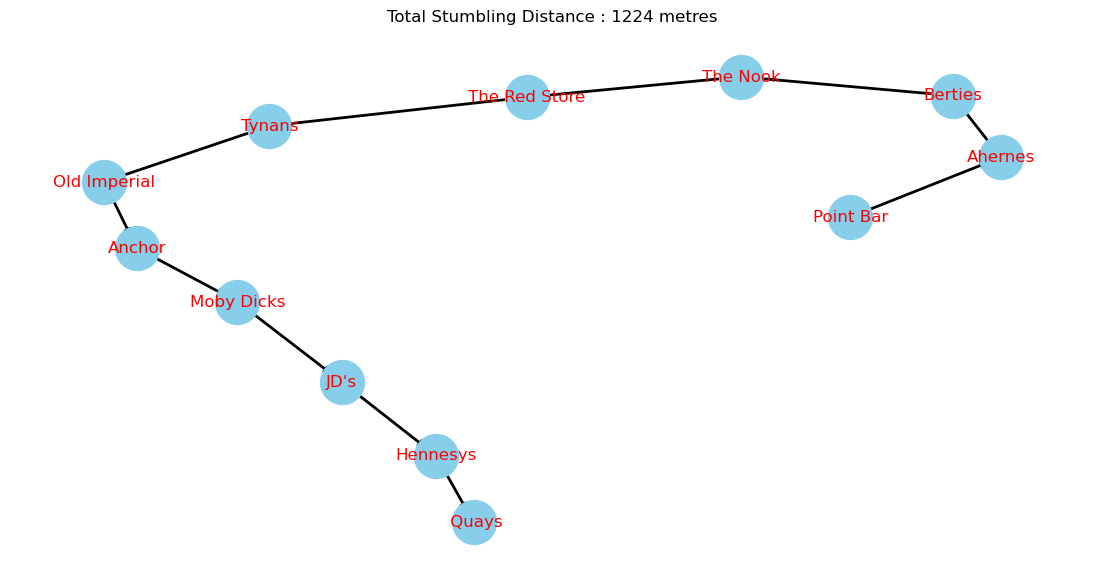

In [282]:
# Function to draw a straight line graph of nodes
def draw_straight_line(nodes, label, numeric_value):
    G = nx.DiGraph()  # Use a directed graph
    
    # Add nodes
    G.add_nodes_from(nodes)
    
    # Add directed edges from left to right
    for i in range(len(nodes) - 1):
        G.add_edge(nodes[i], nodes[i+1])
    
    pos = nx.spring_layout(G)  # Positions of nodes
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=1000, node_color='skyblue')
    
    # Draw directed edges
    nx.draw_networkx_edges(G, pos, width=2.0, edge_color='black', arrows=True)
    
    # Label nodes
    node_labels = {node: str(node) for node in nodes}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color = 'r', font_weight = 8)
    
    plt.gcf().set_size_inches(14,7)  # Adjust figure size based on number of nodes
    plt.axis('off')  # Turn off axis
    plt.title(f"{label} : {numeric_value} metres")
    plt.show()

# Example usage
nodes = list(min_path[::-1])
draw_straight_line(nodes, 'Total Stumbling Distance', min_path_distance)


### A quick note on min heaps

A min heap is a binary tree-based data structure where each node is smaller than or equal to its children. It is commonly used to implement priority queues. 

In a min heap:

 - The root node contains the smallest element in the heap.This is the element at the top of the heap. In our case it was a tuple. We used the heappop method to access this. 
 - For any node i, the element at position i is smaller than or equal to the elements at positions 2i + 1 (left child) and 2i + 2 (right child). This is assuming the min heap is in array format, with i representing the index. For this relationship between parents and children to hold, we assume index 1 is the beginning of the tree. 
 - The heap property ensures that the minimum element is always at the root, making it efficient to find and remove the minimum element.


                   2
                /    \
               4      5
             /  \    /  \
            5    6  7    8

See the above awesome visualisation of a min heap structure, with the smallest element at the top, ready to be popped out

For our above pub algorithm, the runtime complexity, was $O((|V| + |E|) log(|E|))$. This is reached as follows:

- Adding vertices in the graph to a binary heap takes $O(|V|)$ time where |V| is the number of vertices.
- As the algorithm progresses, each update of the binary tree takes log(|V|) time. This will occur |E| times over the course of the network.
- The complete binary tree scales with log n, as each row is double the last, the height $h = 2^{n}$ where n is the number of elements in the tree. the algorithm must travese the height of this tree to select the minimum element, located at the top of the tree.
- The algorithm only removes each vertex once from the priority queue, and which also required the tree to be reordered. Therefore this step takes $|V|log(|V|)$ time.
- Every single edge must be checked, which takes $O(|E|)$ time.
- The two log terms dominate the runtime complexity summation of these steps, so we are therefore left with the above overall complexity. 

# Prim's Algorithm

Prim's algorithm is a greedy algorithm used to find the minimum spanning tree (MST) of a connected, undirected graph. The minimum spanning tree of a graph is a subset of its edges that form a tree connecting all the vertices together with the minimum possible total edge weight.

Here's a brief overview of how Prim's algorithm works:

- Start with an arbitrary vertex as the initial tree (or MST) and mark it as visited. Similar to how we started Dijkstra's. 

 - Repeat the following steps until all vertices are included in the MST:
 - - a. From the vertices that are already in the MST, find the edge with the smallest weight that connects to a vertex not yet in the MST.
 - - b. Add this edge and the connected vertex to the MST, and mark the vertex as visited.

When all vertices are included in the MST, the algorithm terminates.

Prim's algorithm is similar to Dijkstra's algorithm, but instead of finding the shortest path from one vertex to all other vertices, it finds the minimum spanning tree of the entire graph. It is called a greedy algorithm because at each step, it chooses the edge with the smallest weight that connects a vertex in the MST to a vertex outside the MST, without considering the overall structure of the MST.

Anyway, enough blabbing on about it lets get into it.

In [301]:
# Function to find the minimum spanning tree using Prim's algorithm
def prim_mst(graph):
    #Instantiate an empty minimum spanning tree graph
    mst = nx.Graph()
    #Starting at a random node
    start_node = next(iter(graph.nodes())) 
    #Visited set initialised containing only the starting node
    visited = {start_node}
    total_cost = 0
    #We iterate until all nodes have been visited
    while len(visited) < len(graph.nodes()):
        #initilising variables for edge weight, and edge tuple (vertex from, vertex to)
        min_weight = float('inf')
        min_edge = None
        #Checking every vertex wee have been to. This is important as the MST can 'branch' off at any vertex, even ones from previous iterations
        for u in visited:
            #For a given vertex, unpack its adjacent vertexes and the edge weights to those vertexes
            for v, data in graph[u].items():
                #If we haven't been to that vertex, and if it has the minimum edge weight of all adjacent edges
                if v not in visited and data['weight'] < min_weight:
                    min_weight = data['weight']
                    min_edge = (u, v)
                    
        #Adding this edge to our MST, and the edge to our visited set
        u, v = min_edge
        mst.add_edge(u, v, weight=min_weight)
        visited.add(v)
        total_cost += min_weight
    print(total_cost)
    return mst

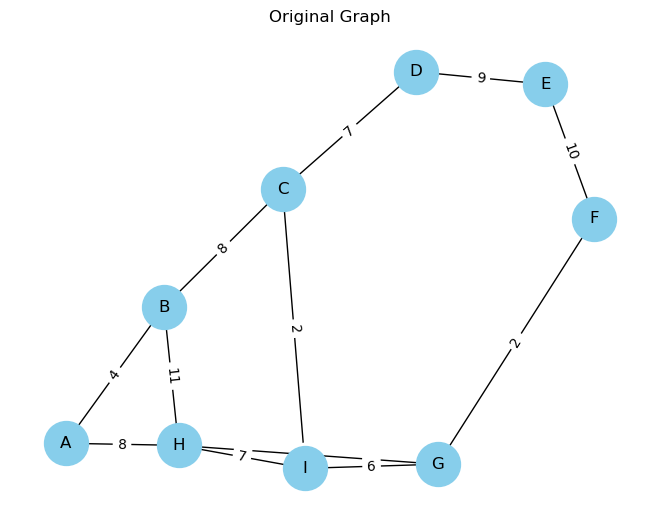

In [297]:
# Example graph
G = nx.Graph()
G.add_edge('A', 'B', weight=4)
G.add_edge('A', 'H', weight=8)
G.add_edge('B', 'H', weight=11)
G.add_edge('B', 'C', weight=8)
G.add_edge('H', 'I', weight=7)
G.add_edge('H', 'G', weight=1)
G.add_edge('I', 'G', weight=6)
G.add_edge('C', 'I', weight=2)
G.add_edge('C', 'D', weight=7)
G.add_edge('G', 'F', weight=2)
G.add_edge('F', 'E', weight=4)
G.add_edge('C', 'D', weight=7)
G.add_edge('D', 'E', weight=9)
G.add_edge('E', 'F', weight=10)

# Draw the network
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='skyblue', font_size=12)
nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in G.edges(data=True)})
plt.title('Original Graph')
plt.show()

39


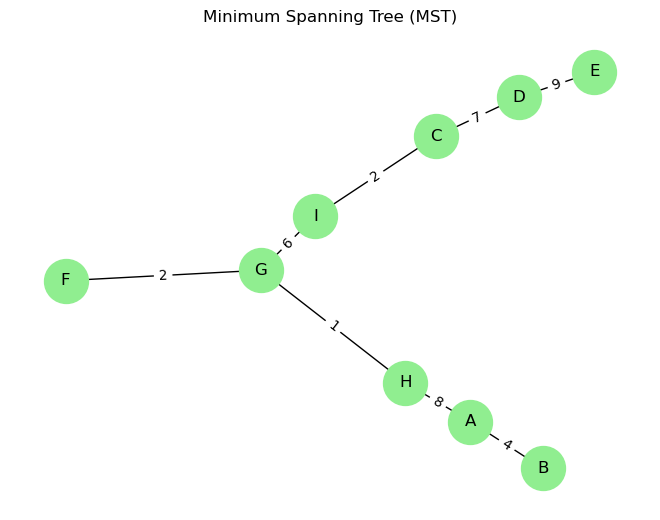

In [302]:
# Find the minimum spanning tree using Prim's algorithm
mst = prim_mst(G)

# Draw the minimum spanning tree
pos_mst = nx.spring_layout(mst)
nx.draw(mst, pos_mst, with_labels=True, node_size=1000, node_color='lightgreen', font_size=12)
nx.draw_networkx_edge_labels(mst, pos_mst, edge_labels={(u, v): d['weight'] for u, v, d in mst.edges(data=True)})
plt.title('Minimum Spanning Tree (MST)')
plt.show()


There we have it. Prim's algorithm succesfully impplemented. I hope you enjoyed our whistlestop tour through network graphs, and the two algorithms we explored. I specifically enjoyed the 12 pubs route calculator myself. 